In [1]:
import torch as tr
import numpy as np
from CSW import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# match human data
- to match human i need to prop one sentence at a time. otherwise the network will do well on later sentences (because after observing one transition the next are determined)
- backprop for each sample, flush at end of story

In [2]:
# task
pr = 1.0
taskL = [CSWTask(pr),CSWTask(1-pr)]
eval_pathL = [
  [10,0,1,4,5],       
  [11,0,1,3,5],
  ]
xeval = taskL[0].format_Xeval(eval_pathL)
xeval = tr.tensor(xeval)

In [29]:
seed = 7

## params

learn_rate = 0.05
# stsize = 40
# neps = 80
# block_len = 40

def train_ret_L_ysm(stsize,neps,block_len):
  ## train setup
  softmax = lambda ulog: tr.softmax(ulog,-1)
  lossop = tr.nn.CrossEntropyLoss()
  lossL = []
  peL = []

  # init net
  net = CSWNet(stsize,seed)
  optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
  model_name='ysm-blocklen%i-seed%i'%(block_len,seed)

  # eval array
  tdim,sm_dim=5,12
  ysm = -np.ones([2,neps,tdim,sm_dim])

  ## train loop
  task_int = 0
  for ep in range(neps):
    if ep == 160:
      block_len = 1
    # select graph
    if ep%block_len==0:
      task_int = (task_int+1)%2
      task = taskL[task_int]
      filler_id = 10+task_int 
    # forward prop  
    path = task.sample_path()
    xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
    yhat = net(xtrain) # (time,smunits)
    ## prediction error
    y1h = tr.nn.functional.one_hot(ytrain,12).squeeze().float()
    pe = np.sum((y1h.detach().numpy()-softmax(yhat).detach().numpy())**2)
    peL.append(pe)
    # eval
    for idx,xev in enumerate(xeval):
      ysm_t = softmax(net(xev)).detach().numpy()
      ysm[idx,ep] = ysm_t
    # backprop
    loss = 0
    for tstep in range(len(xtrain)):
      loss = lossop(yhat[tstep].unsqueeze(0),ytrain[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
    lossL.append(loss.detach().numpy())
  return lossL,peL,ysm

In [30]:
st = 40
ne = 80
Li,PEi,ysmi = train_ret_L_ysm(stsize=st,neps=ne,block_len=1)
Lb,PEb,ysmb = train_ret_L_ysm(stsize=st,neps=ne,block_len=40)

# PE

In [31]:
def mov_avg(A,w=10):
  M = []
  for idx in range(len(A)-w):
    M.append(A[idx:idx+w])
  return np.array(M).mean(1)


## tentative splitting rule
- probability of splitting is proportional to magnitude of positive difference between current PE and local PE average

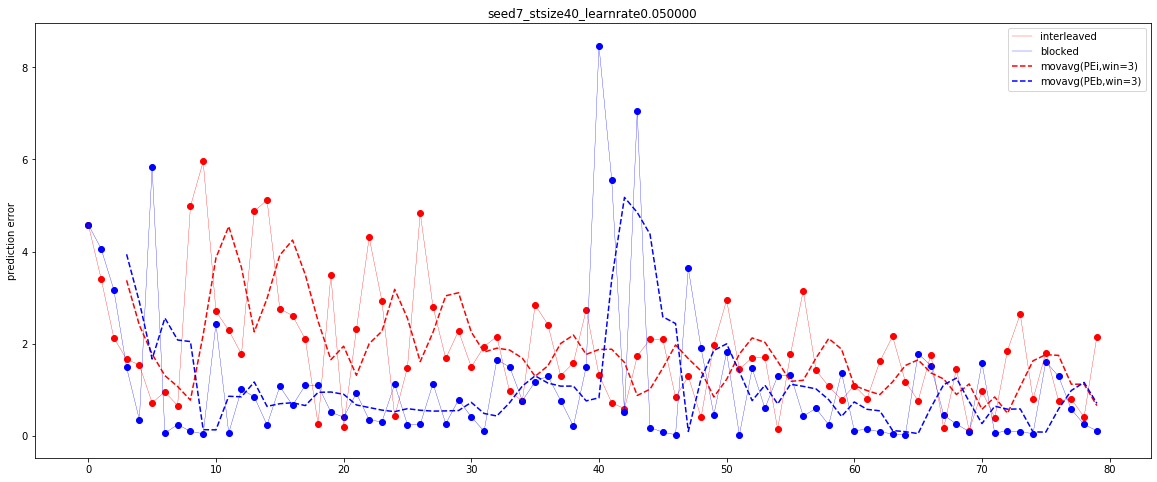

In [32]:
win = 3

plt.figure(figsize=(20,8))
title = 'seed%i_stsize%i_learnrate%f'%(seed,st,learn_rate)
plt.title(title)
plt.plot(PEi,c='r',lw=.3,label='interleaved')
plt.plot(PEb,c='b',lw=.3,label='blocked')
plt.scatter(range(ne),PEi,c='r')
plt.scatter(range(ne),PEb,c='b')
plt.plot(range(win,len(PEi)),mov_avg(PEi,win),c='r',ls='--',label='movavg(PEi,win=%i)'%win)
plt.plot(range(win,len(PEi)),mov_avg(PEb,win),c='b',ls='--',label='movavg(PEb,win=%i)'%win)
plt.legend()
plt.ylabel('prediction error')
plt.savefig('figures/semrep/PE-%s.png'%title)

# loss

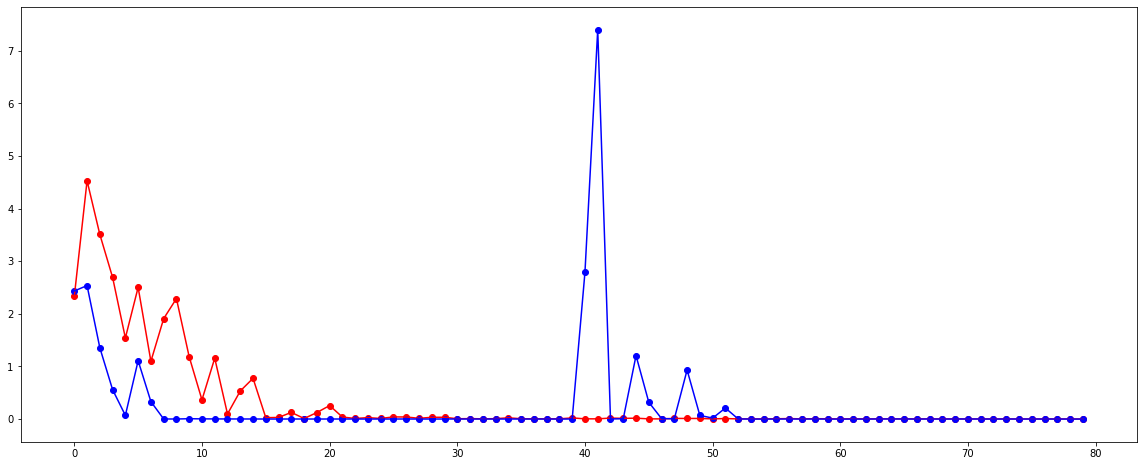

In [7]:
plt.figure(figsize=(20,8))
plt.plot(Li,c='r')
plt.plot(Lb,c='b')
plt.scatter(range(ne),Li,c='r')
plt.scatter(range(ne),Lb,c='b')


# softmax

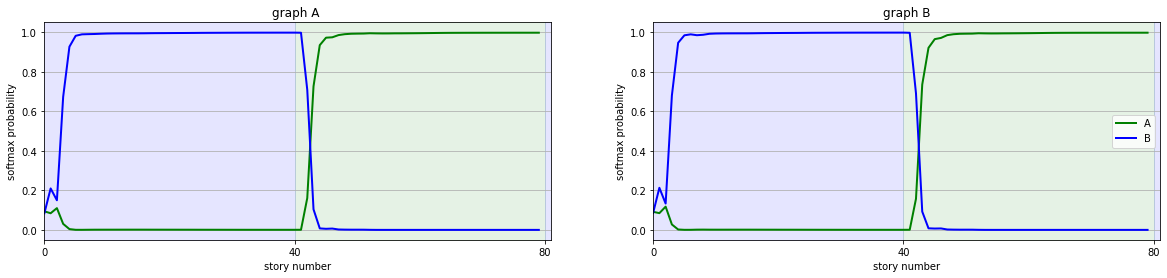

In [8]:
fig,axarr = plt.subplots(1,2,figsize=(20,4))

ysmM = ysmb
# ysmM = ysmi
blocklen=40

tstep = 2
nodes = (3,4)
cL=['g','b']
labL = ['A','B']
tL = ['graph A ','graph B']

for graphid in range(2):
  ax = axarr[graphid]
  ysmM_plt = ysmM[graphid,:,tstep,nodes]

  for idx,M in enumerate(ysmM_plt):
    ax.plot(M,lw=2,c=cL[idx],label=labL[idx])
    ax.set_ylim(-.05,1.05)
    
  if blocklen==40:
    for b in range(4):
      ax.fill_between(range(b*40,(b*40)+41),-0.05,1.05,color=cL[(1+b)%2],alpha=.1)
  else:
    ax.fill_between(range(0,161),-0.05,1.05,color='r',alpha=.1)
  ax.fill_between(range(160,200),-0.05,1.05,color='purple',alpha=.1)
  ax.grid(axis='y')
  ax.set_ylabel('softmax probability')
  ax.set_xlabel('story number')
  ax.set_xticks(range(0,201,40))
  ax.set_title(tL[graphid])
  ax.set_xlim(-.05,81)
plt.legend()
